# Energy Consumption Prediction in Smart Factory

This notebook contains the complete workflow for predicting equipment energy consumption based on sensor data collected from a smart factory.

## 1. Data Loading and Preprocessing

In [2]:
import pandas as pd
import numpy as np

# Load data
data_file = "data/data.csv"
df = pd.read_csv(data_file)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Convert numeric columns from object to float
numeric_cols = df.columns.drop('timestamp')
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing target or timestamp
df = df.dropna(subset=['timestamp', 'equipment_energy_consumption'])

# Fill other missing values with column mean
df = df.fillna(df.mean())

# Display cleaned data info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15945 entries, 0 to 16856
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   timestamp                     15945 non-null  datetime64[ns]
 1   equipment_energy_consumption  15945 non-null  float64       
 2   lighting_energy               15945 non-null  float64       
 3   zone1_temperature             15945 non-null  float64       
 4   zone1_humidity                15945 non-null  float64       
 5   zone2_temperature             15945 non-null  float64       
 6   zone2_humidity                15945 non-null  float64       
 7   zone3_temperature             15945 non-null  float64       
 8   zone3_humidity                15945 non-null  float64       
 9   zone4_temperature             15945 non-null  float64       
 10  zone4_humidity                15945 non-null  float64       
 11  zone5_temperature             159

In [ ]:
#2. Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

# Distribution of target variable
plt.figure(figsize=(8, 6))
sns.histplot(df['equipment_energy_consumption'], bins=50, kde=True)
plt.title('Distribution of Equipment Energy Consumption')
plt.xlabel('Energy Consumption (Wh)')
plt.ylabel('Frequency')
plt.show()

# Scatter plots of selected features vs target
features_to_plot = ['zone1_temperature', 'zone2_temperature', 'outdoor_temperature', 'lighting_energy']
for feature in features_to_plot:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df[feature], y=df['equipment_energy_consumption'])
    plt.title(f'{feature} vs Equipment Energy Consumption')
    plt.xlabel(feature)
    plt.ylabel('Energy Consumption (Wh)')
    plt.show()

Correlation of random_variable1 with target: -0.0158
Correlation of random_variable2 with target: -0.0111


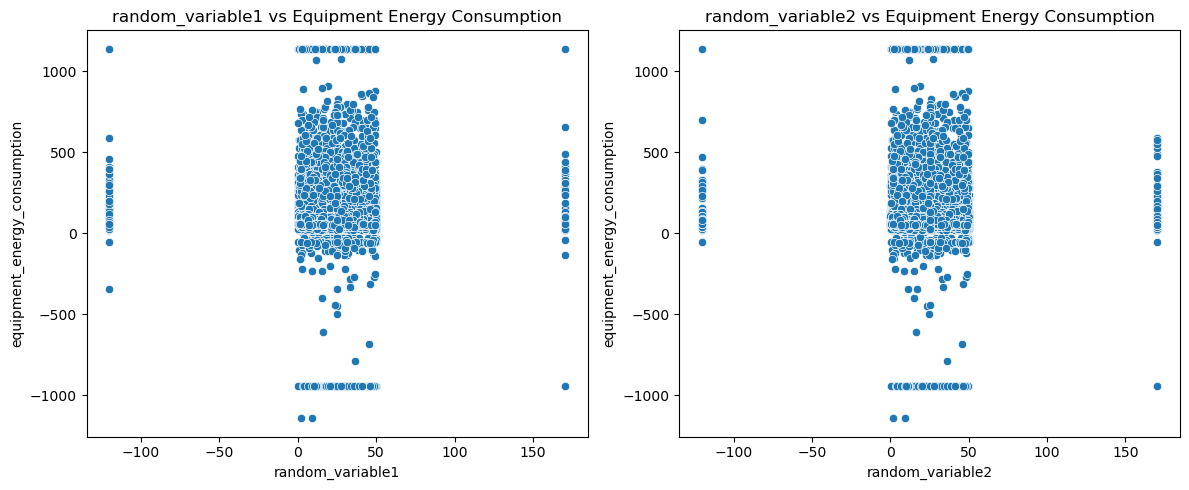

In [4]:
# 3 Analysis of Random Variables
#We analyze the correlation and relationship of random_variable1 and random_variable2 with the target variable to decide whether to include them in the model.

# Correlation of random variables with target
corr_random1 = df['random_variable1'].corr(df['equipment_energy_consumption'])
corr_random2 = df['random_variable2'].corr(df['equipment_energy_consumption'])
print(f"Correlation of random_variable1 with target: {corr_random1:.4f}")
print(f"Correlation of random_variable2 with target: {corr_random2:.4f}")

# Scatter plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=df['random_variable1'], y=df['equipment_energy_consumption'])
plt.title('random_variable1 vs Equipment Energy Consumption')
plt.subplot(1, 2, 2)
sns.scatterplot(x=df['random_variable2'], y=df['equipment_energy_consumption'])
plt.title('random_variable2 vs Equipment Energy Consumption')
plt.tight_layout()
plt.show()


Model performance including random variables:
Tuning Linear Regression...
Linear Regression Performance (exclude_random_vars=False):
RMSE: 163.28
MAE: 74.88
R2: 0.01

Tuning Random Forest...
Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
RMSE: 157.15
MAE: 67.31
R2: 0.08

Tuning Gradient Boosting...
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
RMSE: 159.23
MAE: 68.41
R2: 0.06

Best model: Random Forest (exclude_random_vars=False)


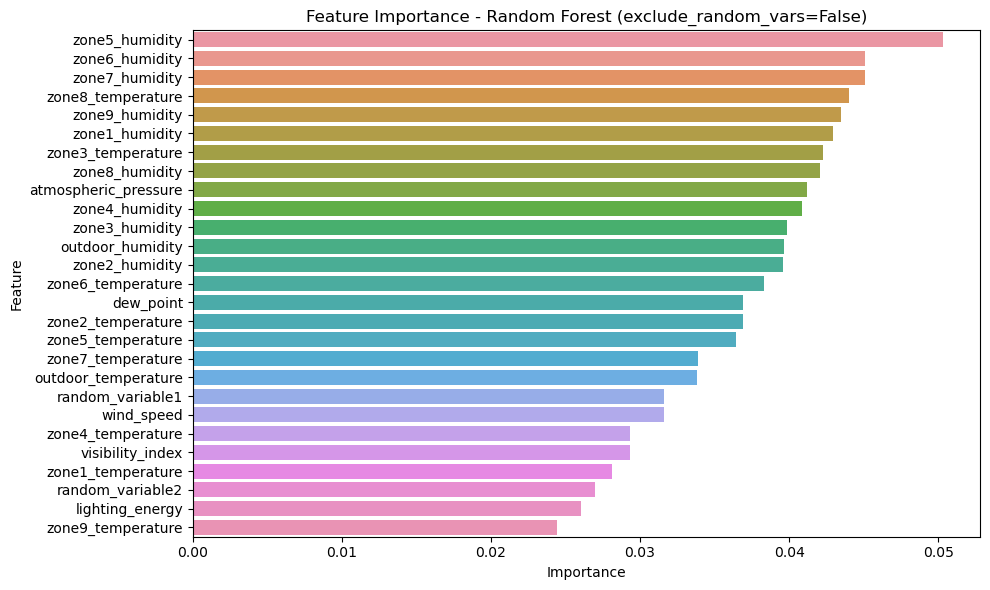

Model performance excluding random variables:
Tuning Linear Regression...
Linear Regression Performance (exclude_random_vars=True):
RMSE: 163.29
MAE: 74.98
R2: 0.01

Tuning Random Forest...
Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
RMSE: 157.83
MAE: 67.09
R2: 0.07

Tuning Gradient Boosting...
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50}
RMSE: 159.32
MAE: 68.19
R2: 0.05

Best model: Random Forest (exclude_random_vars=True)


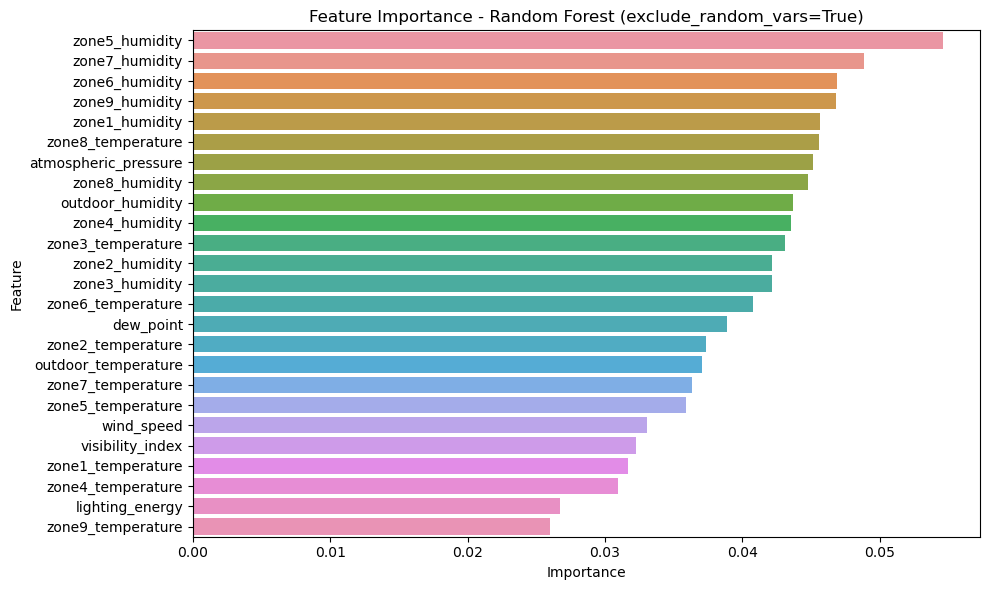

In [7]:
# 4 This section covers training and evaluating regression models with hyperparameter tuning and cross-validation.


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def tune_and_evaluate_model(model, param_grid, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2: {r2:.2f}\n")
    return best_model, rmse, mae, r2

def evaluate_models(df, exclude_random_vars=False):
    if exclude_random_vars:
        X = df.drop(columns=['timestamp', 'equipment_energy_consumption', 'random_variable1', 'random_variable2'])
    else:
        X = df.drop(columns=['timestamp', 'equipment_energy_consumption'])
    y = df['equipment_energy_consumption']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    results = {}
    
    # Linear Regression (no hyperparameters to tune)
    print("Tuning Linear Regression...")
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Linear Regression Performance (exclude_random_vars={exclude_random_vars}):")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2: {r2:.2f}\n")
    results['Linear Regression'] = {'model': lr, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
    
    # Random Forest with hyperparameter tuning
    print("Tuning Random Forest...")
    rf = RandomForestRegressor(random_state=42)
    rf_param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    best_rf, rmse_rf, mae_rf, r2_rf = tune_and_evaluate_model(rf, rf_param_grid, X_train, y_train, X_test, y_test)
    results['Random Forest'] = {'model': best_rf, 'RMSE': rmse_rf, 'MAE': mae_rf, 'R2': r2_rf}
    
    # Gradient Boosting with hyperparameter tuning
    print("Tuning Gradient Boosting...")
    gb = GradientBoostingRegressor(random_state=42)
    gb_param_grid = {
        'n_estimators': [50, 100],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }
    best_gb, rmse_gb, mae_gb, r2_gb = tune_and_evaluate_model(gb, gb_param_grid, X_train, y_train, X_test, y_test)
    results['Gradient Boosting'] = {'model': best_gb, 'RMSE': rmse_gb, 'MAE': mae_gb, 'R2': r2_gb}
    
    # Select best model based on RMSE
    best_model_name = min(results, key=lambda k: results[k]['RMSE'])
    best_model = results[best_model_name]['model']
    print(f"Best model: {best_model_name} (exclude_random_vars={exclude_random_vars})")
    
    # Feature importance for tree-based models
    if best_model_name in ['Random Forest', 'Gradient Boosting']:
        feature_importances = best_model.feature_importances_
        features = X.columns
        fi_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
        fi_df = fi_df.sort_values(by='Importance', ascending=False)
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=fi_df)
        plt.title(f'Feature Importance - {best_model_name} (exclude_random_vars={exclude_random_vars})')
        plt.tight_layout()
        plt.show()
    
    return best_model_name, results[best_model_name]

# Run evaluation and display results
if 'df' in globals():
    print("Model performance including random variables:")
    evaluate_models(df, exclude_random_vars=False)
    print("Model performance excluding random variables:")
    evaluate_models(df, exclude_random_vars=True)
else:
    print("Dataframe 'df' not found. Please load and preprocess the data before running this cell.")